# PRÁCTICA 3: ALGORITMOS GENÉTICOS

#### GLORIA DEL VALLE CANO

In [1]:
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada
import EstrategiaParticionado
import Clasificador
from Clasificador import Clasificador
from Clasificador_AG import Clasificador_AG
from plotModel import plotModel
import numpy as np
import random
import operator
import copy
from math import ceil, floor
from operator import itemgetter
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt
%matplotlib inline
seed = np.random.seed()

In [2]:
dataset1 = Datos('tic-tac-toe.data')
dataset2 = Datos('ejemplo1.data')
dataset3 = Datos('ejemplo2.data')

### Apartado 1:
#### Breve descripción de algunos detalles de la implementación.

Nota: en el constructor de Clasificador_AG se ha añadido un parámetro $\texttt{mostrar_proceso}$ que está por defecto a True para mostrar el desarrollo de cada generacion con el correspondiente fitness del mejor individuo y del fitness medio de la poblacion. Para mostrar la salida únicamente con el resultado final, se debe poner a False.

##### a) Generación de la población inicial con especial indicación del número de reglas por individuo consideradas.

La opción que se ha elegido para la aproximación del cromosoma en esta práctica es el enfoque de $\textit{Pittsburg}$, haciendo que cada individuo represente un conjunto de reglas. El número de estas reglas será variable en función de lo que indiquemos al crear el clasificador. Para realizar esta idea, se ha creado una clase $\textbf{Clasificador_AG}$ que comprende todas las funciones necesarias para la solución y a través de su constructor podemos inicializar este conjunto con el número de reglas (fijo) que le indiquemos. También tenemos la opción de crear un número de reglas aleatorio, entre 1 y el número de reglas que especifiquemos, si el parámetro $\textbf{option}$ del constructor se encuentra a $True$. Para probar con determinación cada una de las combinaciones, se elije determinar el número de reglas fijo para observar con detalle qué sucede en cada número seleccionado. Por defecto, se entrega esta práctica con el parámetro a False.
Es relevante destacar que las reglas son completamente binarias y que tienen el siguiente formato para cada individuo:
$\texttt{[[Atributo 1], [Atributo 2], ..., [Atributo N], [Clase]]}$, donde cada atributo tiene tantos bits como posibilidades de valores haya dentro del mismo atributo, es decir, por ejemplo con tic-tac-toe.data, tenemos para el primer atributo tres posibilidades (b, o, x), por tanto el formato de cada atributo es de tres bits $\texttt{([xxx])}$. Además, las clases sólo guardan dos posibilidades (0 o 1) y los atributos que tratamos en esta práctica sólo serán nominales.

In [6]:
# Constructor de la clase
def __init__(self, dataset, estrategia, mostrar_proceso=True, option=False, n_reglas=4, poblacion=300, generacion=200, cruce=0.85, mutacion=0.1, elitismo=0.05):
    # inicializamos la clase con las probabilidades definidas en el enunciado de la practica
    assert(n_reglas>0)
    self.dataset = dataset
    self.datostrain = []
    # Eleccion del numero de reglas a priori, pasandole la informacion a traves del constructor
    if option == True:
        self.n_reglas = random.randint(1, n_reglas)
    else:
        self.n_reglas = n_reglas
    self.estrategia = estrategia
    self.mostrar_proceso = mostrar_proceso
    self.poblacion = poblacion
    self.generacion = generacion
    self.cruce = cruce
    self.mutacion = mutacion
    self.elitismo = elitismo
    self.best = None
    self.estrategia.creaParticiones(dataset.datos)
    self.datostrain = dataset.extraeDatos(self.estrategia.particiones[-1].indicesTrain)
    self.datostest = dataset.extraeDatos(self.estrategia.particiones[-1].indicesTest)

# Funcion para inicializar un conjunto de reglas
def reglas_ini(self):
    l_r = []
    # para el numero de reglas indicado
    for _ in range(self.n_reglas):
        # para cada atributo
        sub_r = []
        # para cada posibilidad dentro del atributo
        for d in self.dataset.diccionarios[:-1]:
            sub_d = []
            # seleccion de la longitud de la cadena del atributo segun las posibilidades que tengan
            if len(d) == 0:
                longitud = 1
            else:
                longitud = len(d)
            for _ in range(longitud):
                # se generan valores aleatorios dentro de cada atributo entre cero y uno
                sub_d.append(np.random.randint(0,2))
            sub_r.append(sub_d)
        # la clase siempre estara comprendida entre cero y uno
        clase = np.random.randint(0,2)
        sub_r.append([clase])
        # si la regla es todo ceros, no nos vale, tenemos que hacer que sea valida
        aux = self.randomizer(sub_r)
        l_r.append(aux)
    return l_r

# Funcion para generar toda la poblacion
def poblacion_ini(self):
    l_p = []
    for _ in range(self.poblacion):
        l_p.append(self.reglas_ini())
    return l_p

Además de esto, es relevante destacar que ha sido relevante descartar si una regla no es válida, porque con esta implementación se puede dar el caso de que todo el atributo sean 0s. Para evitar esto, se ha decidido implementar una función que evite esto, haciendo que siempre haya al menos un 1.

In [4]:
# Funcion para hacer que haya al menos un 1 en cada atributo
def randomizer(self, progenitor):
    for p in progenitor[:-1]:
        # si son todo 0s
        if (all(v == 0 for v in p)):
            # fuerzo a que en una posicion aleatoria haya un 1
            variacion = random.randint(0,len(p)-1)
            p[variacion] = 1
    return progenitor

##### b) Mecanismo de cruce implementado

Para la implementación del cruce, se han valorado tres de las soluciones más conocidas existentes: el cruce en un punto, el cruce en dos puntos y el cruce uniforme. Finalmente, he elegido el $\textbf{cruce en un punto de corte}$ de todos en el cual dos padres se cortan sus cromosomas por un punto seleccionado aleatoriamente para generar dos segmentos diferenciados en cada uno de ellos: la primera parte y la segunda. Se intercambian ambas partes entre los dos individuos para generar los nuevos descendientes. 
Además se ha decidido que esto se haga en el caso de que se cumpla la probabilidad de cruce.
Se ha llevado a cabo la elección de este método dado que la implementación es sencilla y clara y para los dataset que tenemos genera buenos resultados.

In [ ]:
# Funcion base para hacer el cruce en un punto
def cruce_punto(self, padre1, padre2):
    l1, l2 = [], []
    # se genera una posicion aleatoria donde realizar el cruce
    pos = random.randint(1, min(len(padre1), len(padre2))) -1
    # si se genera una probabilidad que esté dentro de la probabilidad de cruce, se cruzan
    if random.uniform(0,1) <= self.cruce:
        l1 += list(padre1[:pos])
        l1 += list(padre2[pos:])
        l2 += list(padre2[:pos])
        l2 += list(padre1[pos:])
        return l1, l2
    # si no, no se cruzan
    return padre1, padre2

# Funcion para implementar el cruce de todos
def cruzar_ag(self, padres_t):
    l_cruce = []
    mitad = int(len(padres_t)/2)
    for i in range(mitad):
        padre1, padre2 = [], []
        ant = -(i+1)
        long1, long2 = len(padres_t[i]), len(padres_t[ant])
        longitud = min(long1, long2)
        for j in range(longitud):
            # se cruzan ambos padres en un punto
            p1, p2 = self.cruce_punto(padres_t[i][j], padres_t[ant][j])
            padre1.append(p1)
            padre2.append(p2)
        l_cruce.append(padre1)
        l_cruce.append(padre2)
    # cuando el numero de padres no es 2 (par)
    if (len(padres_t) % 2 != 0):
        l_cruce.append(padres_t[-1])
    return l_cruce

##### c) Mecanismo de mutacion implementado

La técnica utilizada para mutar un individuo es la de $\textbf{seleccionar de manera aleatoria un bit y cambiarlo}$, haciendo que se evite en mayor medida mutaciones innecesarias, consumiendo, además, mucho tiempo.

In [7]:
# Funcion base para mutar cada individuo
def mutar_individuo(self, individuo):
    # mutamos para cada regla
    for r in individuo:
        # seleccionamos de manera aleatoria uno de los bits en cada regla
        m = random.randrange(len(r))
        n = random.randrange(len(r[m]))
        # hacemos el swap oportuno para la mutacion
        r[m][n] = 0 if r[m][n] == 1 else 1
    return individuo

# Funcion para mutar una poblacion dada
def mutar(self, poblacion_t):
    l_mutacion = []
    # guardamos en l_mutacion la poblacion total mutada
    for i in poblacion_t:
        # se realizan copias de la poblacion debido a un error previo obtenido que no actualizaban los valores
        copia = copy.deepcopy(i)
        l_mutacion.append(self.mutar_individuo(copia))
    return l_mutacion

##### d) Mecanismo de clasificación implementado
El procedimiento que sigue la clasificación es el de obtener el mejor individuo entrenando tantos datos como generaciones se hayan definido, evaluando la predicción del mejor individuo y viendo si la regla en cuestión se cumple. Finalmente se obtiene un $\textbf{array con la clasificación con todas las clases resultantes}$ para los datostest.

In [ ]:
# Funcion que cuenta las coincidencias encontradas para tratar el fitness y la clasificacion
def conteo_aciertos(self, lista, regla, fila):
    visto = 1
    for i, n in enumerate(fila[:-1]):
        # miramos si la regla es valida
        if (regla[i][int(n)] == 0):
            # si no es valida la descartamos
            visto = 0
            break
        if visto == 0:
            break
    # si es valida la añadimos al conjunto
    if visto:
        lista.append(regla[-1][0])
    return lista
# Funcion para obtener la prediccion
def clasifica(self,datostest,atributosDiscretos,diccionario):
    clasificacion = []
    cont = 0
    # comparamos con datostest
    for f in self.datostest:
        prediccion = []
        for r in self.best:
            prediccion = self.conteo_aciertos(prediccion, r, f)
        # escogemos la mejor prediccion
        if prediccion:
            clasificacion.append(np.argmax(np.bincount(prediccion)))
    return clasificacion

### Apartado 2:
#### Resultados de la clasificación para cada uno de los tres conjuntos de prueba.
Consideraciones previas: utilizo la validación simple ya que las diferencias no son realmente grandes. 
Con el fin de contrastar los resultados, se valora la utilidad de validación cruzada en el último apartado.

In [3]:
tam_pob = [100, 200]
tam_gen = [100, 300]
reglas1 = [2, 5, 20]
reglas2 = [4, 10]
e1 = ValidacionSimple(0.7)
e2 = ValidacionCruzada(5)
estrategias = {'ValidacionSimple': e1, 'ValidacionCruzada': e2}

#### Para tic-tac-toe.data

In [4]:
for r in reglas1:
    for j in tam_pob:
        for k in tam_gen:
            ag = Clasificador_AG(dataset=dataset1, estrategia=e1, mostrar_proceso=True, n_reglas=r, poblacion=j, generacion=k)
            print("________________________________________________________________________________________________________")
            print("Resultados para estrategia =  ValidacionSimple | numero de reglas = ", r, " | tamaño poblacion = ", j, " | numero de generaciones = ", k, "\n")
            error = ag.validacion(e1, dataset1, ag)
            print("Error: ", error)
            print("________________________________________________________________________________________________________")

________________________________________________________________________________________________________
Resultados para estrategia =  ValidacionSimple | numero de reglas =  2  | tamaño poblacion =  100  | numero de generaciones =  100 


Generacion:  1
Mejor fitness:  0.03576751117734724  | Fitness medio poblacion:  0.0029061102831594633

Generacion:  2
Mejor fitness:  0.12369597615499255  | Fitness medio poblacion:  0.01180327868852459

Generacion:  3
Mejor fitness:  0.12518628912071536  | Fitness medio poblacion:  0.027272727272727275

Generacion:  4
Mejor fitness:  0.17585692995529062  | Fitness medio poblacion:  0.048002980625931446

Generacion:  5
Mejor fitness:  0.18479880774962743  | Fitness medio poblacion:  0.06512667660208643

Generacion:  6
Mejor fitness:  0.18032786885245902  | Fitness medio poblacion:  0.07289120715350224

Generacion:  7
Mejor fitness:  0.17883755588673622  | Fitness medio poblacion:  0.09159463487332341

Generacion:  8
Mejor fitness:  0.17883755588673622

Mejor fitness:  0.669150521609538  | Fitness medio poblacion:  0.5937704918032787

Generacion:  82
Mejor fitness:  0.669150521609538  | Fitness medio poblacion:  0.5884500745156482

Generacion:  83
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5802086438152012

Generacion:  84
Mejor fitness:  0.6661698956780924  | Fitness medio poblacion:  0.5843219076005962

Generacion:  85
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5636810730253354

Generacion:  86
Mejor fitness:  0.6602086438152012  | Fitness medio poblacion:  0.5777198211624441

Generacion:  87
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5751564828614009

Generacion:  88
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5890163934426229

Generacion:  89
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5828912071535022

Generacion:  90
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5804023845007452

Generacion:  91
Me

Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.6097019374068554

Generacion:  58
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.6088077496274217

Generacion:  59
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.6010283159463488

Generacion:  60
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.599538002980626

Generacion:  61
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5911475409836067

Generacion:  62
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5897019374068556

Generacion:  63
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5879880774962742

Generacion:  64
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5849180327868853

Generacion:  65
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5800298062593146

Generacion:  66
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5835171385991057

Generacion:  67
M

Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5860357675111774

Generacion:  140
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5914008941877795

Generacion:  141
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5792697466467959

Generacion:  142
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5756482861400894

Generacion:  143
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5770342771982118

Generacion:  144
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5873919523099852

Generacion:  145
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5930253353204172

Generacion:  146
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5749180327868852

Generacion:  147
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5619076005961253

Generacion:  148
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5563189269746647

Generac

Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5669001490312966

Generacion:  222
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5749925484351713

Generacion:  223
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5908941877794337

Generacion:  224
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.587317436661699

Generacion:  225
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5933233979135619

Generacion:  226
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5857377049180328

Generacion:  227
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.599210134128167

Generacion:  228
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5966169895678093

Generacion:  229
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5903129657228018

Generacion:  230
Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5757377049180329

Generacio

Mejor fitness:  0.03278688524590164  | Fitness medio poblacion:  0.0042101341281669145

Generacion:  2
Mejor fitness:  0.04769001490312966  | Fitness medio poblacion:  0.009932935916542474

Generacion:  3
Mejor fitness:  0.09239940387481371  | Fitness medio poblacion:  0.017466467958271236

Generacion:  4
Mejor fitness:  0.10581222056631892  | Fitness medio poblacion:  0.02700447093889717

Generacion:  5
Mejor fitness:  0.17287630402384502  | Fitness medio poblacion:  0.03954545454545455

Generacion:  6
Mejor fitness:  0.20864381520119224  | Fitness medio poblacion:  0.057302533532041726

Generacion:  7
Mejor fitness:  0.23845007451564829  | Fitness medio poblacion:  0.08535022354694487

Generacion:  8
Mejor fitness:  0.2563338301043219  | Fitness medio poblacion:  0.11094634873323399

Generacion:  9
Mejor fitness:  0.31296572280178836  | Fitness medio poblacion:  0.12748882265275707

Generacion:  10
Mejor fitness:  0.31296572280178836  | Fitness medio poblacion:  0.14470193740685544



Mejor fitness:  0.6378539493293591  | Fitness medio poblacion:  0.5527049180327869

Generacion:  84
Mejor fitness:  0.639344262295082  | Fitness medio poblacion:  0.5531371087928466

Generacion:  85
Mejor fitness:  0.6378539493293591  | Fitness medio poblacion:  0.5496795827123697

Generacion:  86
Mejor fitness:  0.639344262295082  | Fitness medio poblacion:  0.5519150521609538

Generacion:  87
Mejor fitness:  0.6363636363636364  | Fitness medio poblacion:  0.56349478390462

Generacion:  88
Mejor fitness:  0.646795827123696  | Fitness medio poblacion:  0.5743293591654248

Generacion:  89
Mejor fitness:  0.646795827123696  | Fitness medio poblacion:  0.5815052160953801

Generacion:  90
Mejor fitness:  0.6408345752608048  | Fitness medio poblacion:  0.5786512667660209

Generacion:  91
Mejor fitness:  0.6438152011922503  | Fitness medio poblacion:  0.5801415797317437

Generacion:  92
Mejor fitness:  0.6438152011922503  | Fitness medio poblacion:  0.578822652757079

Generacion:  93
Mejor f

Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5805514157973174

Generacion:  60
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5980551415797317

Generacion:  61
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.6031892697466468

Generacion:  62
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5960655737704917

Generacion:  63
Mejor fitness:  0.6736214605067065  | Fitness medio poblacion:  0.6023248882265275

Generacion:  64
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5890834575260804

Generacion:  65
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5920864381520119

Generacion:  66
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.578628912071535

Generacion:  67
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5753874813710879

Generacion:  68
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5750596125186289

Generacion:  69
M

Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.593628912071535

Generacion:  142
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5896423248882264

Generacion:  143
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5896348733233978

Generacion:  144
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5826378539493293

Generacion:  145
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5772354694485842

Generacion:  146
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5869895678092399

Generacion:  147
Mejor fitness:  0.6602086438152012  | Fitness medio poblacion:  0.5903725782414306

Generacion:  148
Mejor fitness:  0.6602086438152012  | Fitness medio poblacion:  0.5966691505216094

Generacion:  149
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5874590163934426

Generacion:  150
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.59198956780924

Generacion

Mejor fitness:  0.6602086438152012  | Fitness medio poblacion:  0.5892697466467958

Generacion:  224
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5879210134128167

Generacion:  225
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5881594634873322

Generacion:  226
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.594381520119225

Generacion:  227
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5875111773472429

Generacion:  228
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5876602086438152

Generacion:  229
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5808047690014903

Generacion:  230
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5860357675111773

Generacion:  231
Mejor fitness:  0.6602086438152012  | Fitness medio poblacion:  0.5731594634873323

Generacion:  232
Mejor fitness:  0.6602086438152012  | Fitness medio poblacion:  0.5776080476900148

Generaci

Mejor fitness:  0.06259314456035768  | Fitness medio poblacion:  0.011222056631892699

Generacion:  2
Mejor fitness:  0.26229508196721313  | Fitness medio poblacion:  0.02014903129657228

Generacion:  3
Mejor fitness:  0.2965722801788376  | Fitness medio poblacion:  0.0368554396423249

Generacion:  4
Mejor fitness:  0.30700447093889716  | Fitness medio poblacion:  0.09059612518628914

Generacion:  5
Mejor fitness:  0.3353204172876304  | Fitness medio poblacion:  0.15535022354694486

Generacion:  6
Mejor fitness:  0.36363636363636365  | Fitness medio poblacion:  0.19898658718330847

Generacion:  7
Mejor fitness:  0.36065573770491804  | Fitness medio poblacion:  0.22187779433681068

Generacion:  8
Mejor fitness:  0.4336810730253353  | Fitness medio poblacion:  0.23032786885245904

Generacion:  9
Mejor fitness:  0.3859910581222057  | Fitness medio poblacion:  0.24332339791356183

Generacion:  10
Mejor fitness:  0.4232488822652757  | Fitness medio poblacion:  0.25

Generacion:  11
Mejor fi

Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5649776453055142

Generacion:  85
Mejor fitness:  0.6527570789865872  | Fitness medio poblacion:  0.5896572280178837

Generacion:  86
Mejor fitness:  0.6527570789865872  | Fitness medio poblacion:  0.590461997019374

Generacion:  87
Mejor fitness:  0.6527570789865872  | Fitness medio poblacion:  0.5947391952309985

Generacion:  88
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.594441132637854

Generacion:  89
Mejor fitness:  0.6572280178837556  | Fitness medio poblacion:  0.5890611028315946

Generacion:  90
Mejor fitness:  0.6572280178837556  | Fitness medio poblacion:  0.5887332339791357

Generacion:  91
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.58397913561848

Generacion:  92
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5726229508196722

Generacion:  93
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5780923994038748

Generacion:  94
Mejo

Mejor fitness:  0.6453055141579732  | Fitness medio poblacion:  0.5825484351713859

Generacion:  58
Mejor fitness:  0.6482861400894188  | Fitness medio poblacion:  0.5890163934426229

Generacion:  59
Mejor fitness:  0.6482861400894188  | Fitness medio poblacion:  0.5827719821162445

Generacion:  60
Mejor fitness:  0.646795827123696  | Fitness medio poblacion:  0.5959016393442622

Generacion:  61
Mejor fitness:  0.6453055141579732  | Fitness medio poblacion:  0.587064083457526

Generacion:  62
Mejor fitness:  0.6438152011922503  | Fitness medio poblacion:  0.5829061102831594

Generacion:  63
Mejor fitness:  0.6497764530551415  | Fitness medio poblacion:  0.5664232488822651

Generacion:  64
Mejor fitness:  0.6453055141579732  | Fitness medio poblacion:  0.5738301043219075

Generacion:  65
Mejor fitness:  0.6438152011922503  | Fitness medio poblacion:  0.575111773472429

Generacion:  66
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5744411326378539

Generacion:  67
Mej

Mejor fitness:  0.6512667660208644  | Fitness medio poblacion:  0.5736214605067064

Generacion:  140
Mejor fitness:  0.6482861400894188  | Fitness medio poblacion:  0.5731296572280179

Generacion:  141
Mejor fitness:  0.6497764530551415  | Fitness medio poblacion:  0.5820119225037258

Generacion:  142
Mejor fitness:  0.6482861400894188  | Fitness medio poblacion:  0.5875558867362145

Generacion:  143
Mejor fitness:  0.646795827123696  | Fitness medio poblacion:  0.5878539493293591

Generacion:  144
Mejor fitness:  0.6482861400894188  | Fitness medio poblacion:  0.5650074515648285

Generacion:  145
Mejor fitness:  0.6497764530551415  | Fitness medio poblacion:  0.567004470938897

Generacion:  146
Mejor fitness:  0.646795827123696  | Fitness medio poblacion:  0.5668554396423249

Generacion:  147
Mejor fitness:  0.646795827123696  | Fitness medio poblacion:  0.56876304023845

Generacion:  148
Mejor fitness:  0.646795827123696  | Fitness medio poblacion:  0.5791654247391953

Generacion:  1

Mejor fitness:  0.6527570789865872  | Fitness medio poblacion:  0.571371087928465

Generacion:  222
Mejor fitness:  0.6527570789865872  | Fitness medio poblacion:  0.5754694485842027

Generacion:  223
Mejor fitness:  0.6527570789865872  | Fitness medio poblacion:  0.5811922503725783

Generacion:  224
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5575409836065573

Generacion:  225
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5855290611028316

Generacion:  226
Mejor fitness:  0.6572280178837556  | Fitness medio poblacion:  0.6058271236959761

Generacion:  227
Mejor fitness:  0.6572280178837556  | Fitness medio poblacion:  0.6020417287630402

Generacion:  228
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.6065722801788375

Generacion:  229
Mejor fitness:  0.6482861400894188  | Fitness medio poblacion:  0.6039046199701936

Generacion:  230
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5936512667660208

Generaci


Generacion:  1
Mejor fitness:  0.13114754098360656  | Fitness medio poblacion:  0.009470938897168405

Generacion:  2
Mejor fitness:  0.18032786885245902  | Fitness medio poblacion:  0.025737704918032785

Generacion:  3
Mejor fitness:  0.16989567809239942  | Fitness medio poblacion:  0.05114754098360656

Generacion:  4
Mejor fitness:  0.20566318926974664  | Fitness medio poblacion:  0.07450074515648286

Generacion:  5
Mejor fitness:  0.3174366616989568  | Fitness medio poblacion:  0.1002086438152012

Generacion:  6
Mejor fitness:  0.323397913561848  | Fitness medio poblacion:  0.12198211624441133

Generacion:  7
Mejor fitness:  0.3293591654247392  | Fitness medio poblacion:  0.142220566318927

Generacion:  8
Mejor fitness:  0.33084947839046197  | Fitness medio poblacion:  0.16076005961251866

Generacion:  9
Mejor fitness:  0.3412816691505216  | Fitness medio poblacion:  0.18003725782414307

Generacion:  10
Mejor fitness:  0.4143070044709389  | Fitness medio poblacion:  0.19854694485842

Mejor fitness:  0.6661698956780924  | Fitness medio poblacion:  0.6027049180327869

Generacion:  84
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.594769001490313

Generacion:  85
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5888748137108792

Generacion:  86
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5848509687034277

Generacion:  87
Mejor fitness:  0.6631892697466468  | Fitness medio poblacion:  0.57274217585693

Generacion:  88
Mejor fitness:  0.6676602086438153  | Fitness medio poblacion:  0.5797242921013412

Generacion:  89
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.5774739195230998

Generacion:  90
Mejor fitness:  0.6706408345752608  | Fitness medio poblacion:  0.5838301043219076

Generacion:  91
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5806259314456035

Generacion:  92
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5831445603576751

Generacion:  93
Mej

Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.6013859910581222

Generacion:  57
Mejor fitness:  0.6825633383010432  | Fitness medio poblacion:  0.6054619970193741

Generacion:  58
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.6078614008941878

Generacion:  59
Mejor fitness:  0.6795827123695977  | Fitness medio poblacion:  0.6006035767511176

Generacion:  60
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.6092548435171385

Generacion:  61
Mejor fitness:  0.6825633383010432  | Fitness medio poblacion:  0.6167511177347242

Generacion:  62
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.6104694485842027

Generacion:  63
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.5975931445603577

Generacion:  64
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.6004545454545454

Generacion:  65
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.6074143070044709

Generacion:  66
Mejo

Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.6078614008941877

Generacion:  139
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.6000819672131147

Generacion:  140
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.5958420268256333

Generacion:  141
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.5984128166915051

Generacion:  142
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.600171385991058

Generacion:  143
Mejor fitness:  0.6751117734724292  | Fitness medio poblacion:  0.5998435171385991

Generacion:  144
Mejor fitness:  0.6810730253353204  | Fitness medio poblacion:  0.6050670640834575

Generacion:  145
Mejor fitness:  0.6825633383010432  | Fitness medio poblacion:  0.6059761549925483

Generacion:  146
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.6045007451564828

Generacion:  147
Mejor fitness:  0.6810730253353204  | Fitness medio poblacion:  0.6011400894187778

Generacion:  1

Mejor fitness:  0.6751117734724292  | Fitness medio poblacion:  0.5981743666169895

Generacion:  221
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.5950447093889717

Generacion:  222
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.5902533532041728

Generacion:  223
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.6066244411326377

Generacion:  224
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.6115201192250371

Generacion:  225
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.6157749627421758

Generacion:  226
Mejor fitness:  0.6795827123695977  | Fitness medio poblacion:  0.6174292101341281

Generacion:  227
Mejor fitness:  0.6810730253353204  | Fitness medio poblacion:  0.6072801788375558

Generacion:  228
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.6003427719821162

Generacion:  229
Mejor fitness:  0.6751117734724292  | Fitness medio poblacion:  0.6046721311475409

Generaci


Generacion:  1
Mejor fitness:  0.11624441132637854  | Fitness medio poblacion:  0.039895678092399404

Generacion:  2
Mejor fitness:  0.11177347242921014  | Fitness medio poblacion:  0.04682563338301042

Generacion:  3
Mejor fitness:  0.11177347242921014  | Fitness medio poblacion:  0.04921013412816691

Generacion:  4
Mejor fitness:  0.12518628912071536  | Fitness medio poblacion:  0.05296572280178838

Generacion:  5
Mejor fitness:  0.23397913561847988  | Fitness medio poblacion:  0.062876304023845

Generacion:  6
Mejor fitness:  0.21758569299552907  | Fitness medio poblacion:  0.07016393442622951

Generacion:  7
Mejor fitness:  0.23099850968703428  | Fitness medio poblacion:  0.07879284649776452

Generacion:  8
Mejor fitness:  0.22354694485842028  | Fitness medio poblacion:  0.08673621460506707

Generacion:  9
Mejor fitness:  0.23695976154992549  | Fitness medio poblacion:  0.09549925484351714

Generacion:  10
Mejor fitness:  0.22652757078986588  | Fitness medio poblacion:  0.10089418

Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5583159463487333

Generacion:  84
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5525335320417288

Generacion:  85
Mejor fitness:  0.669150521609538  | Fitness medio poblacion:  0.5559314456035768

Generacion:  86
Mejor fitness:  0.6676602086438153  | Fitness medio poblacion:  0.5504769001490313

Generacion:  87
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5444560357675112

Generacion:  88
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5496274217585694

Generacion:  89
Mejor fitness:  0.6572280178837556  | Fitness medio poblacion:  0.5490163934426229

Generacion:  90
Mejor fitness:  0.6557377049180327  | Fitness medio poblacion:  0.5523546944858421

Generacion:  91
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5522354694485843

Generacion:  92
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5544709388971684

Generacion:  93
M

Mejor fitness:  0.6631892697466468  | Fitness medio poblacion:  0.48339791356184797

Generacion:  41
Mejor fitness:  0.6602086438152012  | Fitness medio poblacion:  0.4885692995529061

Generacion:  42
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.48515648286140084

Generacion:  43
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.49236959761549925

Generacion:  44
Mejor fitness:  0.6527570789865872  | Fitness medio poblacion:  0.492414307004471

Generacion:  45
Mejor fitness:  0.6587183308494784  | Fitness medio poblacion:  0.49567809239940386

Generacion:  46
Mejor fitness:  0.6572280178837556  | Fitness medio poblacion:  0.5053055141579732

Generacion:  47
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5067660208643815

Generacion:  48
Mejor fitness:  0.6616989567809239  | Fitness medio poblacion:  0.5113561847988076

Generacion:  49
Mejor fitness:  0.6602086438152012  | Fitness medio poblacion:  0.5117883755588674

Generacion:  

Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.6022652757078987

Generacion:  123
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.5919374068554397

Generacion:  124
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5948882265275709

Generacion:  125
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5867362146050671

Generacion:  126
Mejor fitness:  0.6661698956780924  | Fitness medio poblacion:  0.5821013412816691

Generacion:  127
Mejor fitness:  0.6676602086438153  | Fitness medio poblacion:  0.5924143070044711

Generacion:  128
Mejor fitness:  0.6736214605067065  | Fitness medio poblacion:  0.5929657228017884

Generacion:  129
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.5915201192250372

Generacion:  130
Mejor fitness:  0.684053651266766  | Fitness medio poblacion:  0.5997764530551415

Generacion:  131
Mejor fitness:  0.6736214605067065  | Fitness medio poblacion:  0.598360655737705

Generacio

Mejor fitness:  0.684053651266766  | Fitness medio poblacion:  0.5993889716840536

Generacion:  205
Mejor fitness:  0.6795827123695977  | Fitness medio poblacion:  0.5912071535022354

Generacion:  206
Mejor fitness:  0.6795827123695977  | Fitness medio poblacion:  0.598628912071535

Generacion:  207
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.6005216095380029

Generacion:  208
Mejor fitness:  0.6736214605067065  | Fitness medio poblacion:  0.5912518628912071

Generacion:  209
Mejor fitness:  0.6855439642324889  | Fitness medio poblacion:  0.5866169895678092

Generacion:  210
Mejor fitness:  0.6706408345752608  | Fitness medio poblacion:  0.587585692995529

Generacion:  211
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5708047690014904

Generacion:  212
Mejor fitness:  0.6959761549925484  | Fitness medio poblacion:  0.5800000000000001

Generacion:  213
Mejor fitness:  0.6959761549925484  | Fitness medio poblacion:  0.5751713859910581

Generacion

Mejor fitness:  0.6795827123695977  | Fitness medio poblacion:  0.5701490312965724

Generacion:  287
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5751564828614009

Generacion:  288
Mejor fitness:  0.6885245901639344  | Fitness medio poblacion:  0.5805365126676602

Generacion:  289
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.57150521609538

Generacion:  290
Mejor fitness:  0.6795827123695977  | Fitness medio poblacion:  0.5653204172876304

Generacion:  291
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5638301043219076

Generacion:  292
Mejor fitness:  0.6795827123695977  | Fitness medio poblacion:  0.5646348733233979

Generacion:  293
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5480476900149032

Generacion:  294
Mejor fitness:  0.6706408345752608  | Fitness medio poblacion:  0.5548584202682564

Generacion:  295
Mejor fitness:  0.6736214605067065  | Fitness medio poblacion:  0.5515648286140089

Generacio


Generacion:  43
Mejor fitness:  0.6736214605067065  | Fitness medio poblacion:  0.5745454545454546

Generacion:  44
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.5741579731743667

Generacion:  45
Mejor fitness:  0.6780923994038748  | Fitness medio poblacion:  0.5794262295081967

Generacion:  46
Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.5697242921013412

Generacion:  47
Mejor fitness:  0.684053651266766  | Fitness medio poblacion:  0.5570566318926974

Generacion:  48
Mejor fitness:  0.6810730253353204  | Fitness medio poblacion:  0.565134128166915

Generacion:  49
Mejor fitness:  0.6751117734724292  | Fitness medio poblacion:  0.569672131147541

Generacion:  50
Mejor fitness:  0.6706408345752608  | Fitness medio poblacion:  0.5785096870342772

Generacion:  51
Mejor fitness:  0.684053651266766  | Fitness medio poblacion:  0.5763934426229508

Generacion:  52
Mejor fitness:  0.684053651266766  | Fitness medio poblacion:  0.5748062593144561

Gener


Generacion:  1
Mejor fitness:  0.19821162444113263  | Fitness medio poblacion:  0.04088673621460507

Generacion:  2
Mejor fitness:  0.2637853949329359  | Fitness medio poblacion:  0.05093144560357676

Generacion:  3
Mejor fitness:  0.31892697466467956  | Fitness medio poblacion:  0.06508941877794337

Generacion:  4
Mejor fitness:  0.3204172876304024  | Fitness medio poblacion:  0.0761624441132638

Generacion:  5
Mejor fitness:  0.3770491803278688  | Fitness medio poblacion:  0.09082712369597616

Generacion:  6
Mejor fitness:  0.4157973174366617  | Fitness medio poblacion:  0.12145305514157974

Generacion:  7
Mejor fitness:  0.44709388971684055  | Fitness medio poblacion:  0.16076005961251866

Generacion:  8
Mejor fitness:  0.43815201192250375  | Fitness medio poblacion:  0.18830104321907598

Generacion:  9
Mejor fitness:  0.4798807749627422  | Fitness medio poblacion:  0.210096870342772

Generacion:  10
Mejor fitness:  0.481371087928465  | Fitness medio poblacion:  0.22610283159463487

Mejor fitness:  0.676602086438152  | Fitness medio poblacion:  0.5873845007451566

Generacion:  84
Mejor fitness:  0.6959761549925484  | Fitness medio poblacion:  0.5938450074515649

Generacion:  85
Mejor fitness:  0.684053651266766  | Fitness medio poblacion:  0.5867660208643816

Generacion:  86
Mejor fitness:  0.6870342771982116  | Fitness medio poblacion:  0.5782712369597616

Generacion:  87
Mejor fitness:  0.6751117734724292  | Fitness medio poblacion:  0.5721758569299553

Generacion:  88
Mejor fitness:  0.6900149031296572  | Fitness medio poblacion:  0.577585692995529

Generacion:  89
Mejor fitness:  0.6900149031296572  | Fitness medio poblacion:  0.5799478390461996

Generacion:  90
Mejor fitness:  0.6900149031296572  | Fitness medio poblacion:  0.5811028315946348

Generacion:  91
Mejor fitness:  0.6900149031296572  | Fitness medio poblacion:  0.5797839046199702

Generacion:  92
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5758196721311475

Generacion:  93
Mej


Generacion:  165
Mejor fitness:  0.6870342771982116  | Fitness medio poblacion:  0.5821087928464977

Generacion:  166
Mejor fitness:  0.669150521609538  | Fitness medio poblacion:  0.5765201192250372

Generacion:  167
Mejor fitness:  0.6646795827123696  | Fitness medio poblacion:  0.5818777943368107

Generacion:  168
Mejor fitness:  0.6661698956780924  | Fitness medio poblacion:  0.5700968703427719

Generacion:  169
Mejor fitness:  0.6751117734724292  | Fitness medio poblacion:  0.5778763040238449

Generacion:  170
Mejor fitness:  0.6825633383010432  | Fitness medio poblacion:  0.5810581222056632

Generacion:  171
Mejor fitness:  0.6706408345752608  | Fitness medio poblacion:  0.5870864381520119

Generacion:  172
Mejor fitness:  0.6661698956780924  | Fitness medio poblacion:  0.5713412816691504

Generacion:  173
Mejor fitness:  0.6721311475409836  | Fitness medio poblacion:  0.5839791356184798

Generacion:  174
Mejor fitness:  0.6676602086438153  | Fitness medio poblacion:  0.57655737


Generacion:  247
Mejor fitness:  0.6810730253353204  | Fitness medio poblacion:  0.5687332339791357

Generacion:  248
Mejor fitness:  0.6974664679582713  | Fitness medio poblacion:  0.5727719821162445

Generacion:  249
Mejor fitness:  0.7034277198211625  | Fitness medio poblacion:  0.5728837555886735

Generacion:  250
Mejor fitness:  0.698956780923994  | Fitness medio poblacion:  0.5826751117734724

Generacion:  251
Mejor fitness:  0.6944858420268256  | Fitness medio poblacion:  0.590946348733234

Generacion:  252
Mejor fitness:  0.6929955290611028  | Fitness medio poblacion:  0.5901043219076005

Generacion:  253
Mejor fitness:  0.6929955290611028  | Fitness medio poblacion:  0.5889865871833085

Generacion:  254
Mejor fitness:  0.7019374068554396  | Fitness medio poblacion:  0.5906706408345752

Generacion:  255
Mejor fitness:  0.7049180327868853  | Fitness medio poblacion:  0.5874068554396423

Generacion:  256
Mejor fitness:  0.6870342771982116  | Fitness medio poblacion:  0.577831594

Dados los resultados obtenidos podemos obtener las siguientes conclusiones para este dataset:
* Parece que a partir de la generación 200, el fitness comienza a mantenerse, por lo que podríamos decir que no es necesario realizar muchas más, ya que también podríamos llegar a un sobreajuste de los datos que queremos evitar.
* También parece que cuantas más reglas se utilicen también se obtiene en anteriores generaciones un fitness adecuado, y que 2 reglas no son suficientes.
* Se observa que el error es bastante similar al que obtuvimos con Naive Bayes, por lo que parece que el clasificador realiza las operaciones básicas, pero puede ser mejorable.
* También se ve que a partir de 20 generaciones empezamos a obtener valores de fitness más adecuados, dadas las características del dataset.
* Además parece que en este caso la variación de utilizar una población de 100 y otra de 200 no es para nada grande.

#### Para ejemplo1.data

In [4]:
for r in reglas2:
    for j in tam_pob:
        for k in tam_gen:
            ag = Clasificador_AG(dataset=dataset2, estrategia=e1, mostrar_proceso=False, n_reglas=r, poblacion=j, generacion=k)
            print("________________________________________________________________________________________________________")
            print("Resultados para estrategia = ValidacionSimple | tamaño poblacion = ", j, " | numero de generaciones = ", k, "\n")
            error = ag.validacion(e1, dataset2, ag)
            print("Error: ", error)
            print("________________________________________________________________________________________________________")

________________________________________________________________________________________________________
Resultados para estrategia = ValidacionSimple | tamaño poblacion =  100  | numero de generaciones =  100 

Best:  [[[0, 1], [1, 0], [0]], [[1, 0], [0, 1], [0]], [[0, 1], [0, 0], [0]], [[1, 1], [1, 1], [1]]] | fit: 1.0
Error:  0.0
________________________________________________________________________________________________________
________________________________________________________________________________________________________
Resultados para estrategia = ValidacionSimple | tamaño poblacion =  100  | numero de generaciones =  300 

Best:  [[[1, 1], [1, 1], [1]], [[0, 1], [0, 0], [1]], [[1, 0], [0, 1], [0]], [[0, 1], [1, 0], [0]]] | fit: 1.0
Error:  0.48333333333333334
________________________________________________________________________________________________________
________________________________________________________________________________________________________

#### Para ejemplo2.data

In [5]:
for r in reglas2:
    for j in tam_pob:
        for k in tam_gen:
            ag = Clasificador_AG(dataset=dataset3, estrategia=e1, mostrar_proceso=False, n_reglas=r, poblacion=j, generacion=k)
            print("________________________________________________________________________________________________________")
            print("Resultados para estrategia = ValidacionSimple | tamaño poblacion = ", j, " | numero de generaciones = ", k, "\n")
            error = ag.validacion(e1, dataset3, ag)
            print("Error: ", error)
            print("________________________________________________________________________________________________________")

________________________________________________________________________________________________________
Resultados para estrategia = ValidacionSimple | tamaño poblacion =  100  | numero de generaciones =  100 

Best:  [[[1, 0], [1, 1], [0]], [[1, 0], [1, 1], [0]], [[1, 1], [1, 1], [1]], [[0, 1], [1, 1], [1]]] | fit: 1.0
Error:  0.48333333333333334
________________________________________________________________________________________________________
________________________________________________________________________________________________________
Resultados para estrategia = ValidacionSimple | tamaño poblacion =  100  | numero de generaciones =  300 

Best:  [[[1, 0], [1, 1], [0]], [[0, 1], [1, 1], [1]], [[1, 0], [1, 1], [0]], [[1, 1], [1, 1], [1]]] | fit: 1.0
Error:  0.5333333333333333
________________________________________________________________________________________________________
_________________________________________________________________________________________

Observamos que el error debería ser 0 para este tipo de datasets.
Sin embargo, debo estar realizando algo mal y no he podido localizar el error, por lo que es necesario resolver esto para dar por bueno el algoritmo. Sospecho que es algo que no he contemplado en el notebook. No sé por qué al ejecutar cada combinacion de manera individual por terminal el error da 0.0, y en estas ejecuciones es así.

### Apartado 3:
#### Análisis de los resultados: importancia del número de reglas, tamaño de la población, generaciones, tasas de cruce y mutación.

* Dados los resultados que se han obtenido, es relevante destacar la observación de que se obtiene un mejor fitness cuanto mayor es el número de reglas, ya que va a haber más posibilidad de aciertos, pero dependiendo del dataset, no es necesario pasar de un determinado número. Por ejemplo parece que 20 reglas está bien para tic-tac-toe.data.
* También es relevante el tamaño de la población elegido. Cuanto mayor sea, encontraremos un mejor individuo, al igual que con el número de generaciones, pero existe un punto en el que el algoritmo converge y no llega a ser necesario continuar iterando a partir de tal punto.
* En cuanto a las tasas de cruce y de mutación es relevante destacar que la probabilidad de mutación debe ser bastante menor que la de cruce, ya que la modificación que se realiza en la población debe ser una pequeña parte, al contrario que en el cruce, ya que representa una mayor variedad por lo que se puede llegar a tener más aciertos, por tanto, un fitness mejor.
* Como crítica, se espera mejorar este algoritmo. Además se valora la posibilidad en un futuro de valorar qué hacer con la población siguiente, es decir, poder re-aplicar una probabilidad de cruce y mutacion distinto a una selección de individuos. Esto podría mejorar no sólo la ejecución del algoritmo, sino que, dependiendo del dataset se puede obtener buenos resultados. También se abre la posibilidad de utilizar quickselect para ir encontrando la población siguiente, dado que creo que no es realmente necesario ordenar toda la tupla de población y fitness en entrenamiento.

### Apartado 4:
#### Solo para la fase de entrenamiento, evolución en forma de gráfica.

In [6]:
d_dataset = {'tic-tac-toe.data': dataset1, 'ejemplo1.data': dataset2, 'ejemplo2.data': dataset3}
def graficas_a4(titulo, mejor_l_fit, mejor_l_pob):
    plt.title(titulo)
    plt.xlabel('N generacion')
    plt.ylabel('Fitness')
    plt.plot(mejor_l_fit, 'c-*', label='Fitness del individuo')
    plt.plot(mejor_l_pob, 'm-o', label='Fitness medio de la poblacion')
    plt.legend()
    plt.show()

#### a) Del fitness del mejor individuo de la población
#### b) Del fitness medio de la población
##### Se incluyen pruebas con ValidacionSimple y ValidacionCruzada. Probamos con 5 reglas y 200 generaciones.

$ValidacionSimple$

Best:  [[[1, 1, 0], [0, 1, 1], [1, 1, 1], [1, 0, 1], [1, 1, 0], [0, 1, 1], [1, 1, 0], [0, 1, 1], [0, 0, 0], [0]], [[1, 1, 0], [0, 1, 1], [1, 1, 0], [1, 0, 1], [1, 1, 1], [0, 0, 1], [0, 0, 1], [0, 1, 0], [1, 0, 1], [0]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1]], [[1, 1, 0], [1, 0, 0], [0, 0, 0], [1, 1, 0], [1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [0, 1, 1], [1]], [[0, 0, 0], [0, 0, 1], [0, 0, 0], [1, 0, 1], [1, 1, 0], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 1, 1], [1]]] | fit: 0.676602086438152


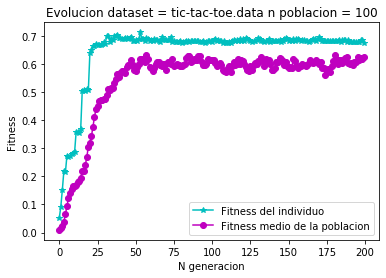

Best:  [[[0, 0, 0], [0, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 1, 1], [1, 0, 1], [0, 1, 0], [1]], [[0, 0, 1], [1, 0, 1], [0, 0, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 0, 1], [0, 0, 1], [1, 1, 1], [0]], [[0, 1, 1], [0, 0, 1], [1, 0, 0], [0, 1, 1], [1, 0, 1], [0, 0, 1], [0, 1, 0], [1, 1, 0], [1, 0, 1], [0]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1]], [[1, 0, 0], [0, 0, 1], [1, 1, 1], [0, 0, 0], [0, 1, 1], [0, 1, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [1]]] | fit: 0.6497764530551415


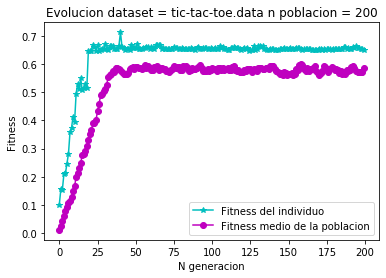

Best:  [[[1, 1], [1, 1], [1]], [[0, 1], [1, 0], [0]], [[1, 0], [0, 1], [0]], [[0, 0], [1, 0], [0]], [[1, 0], [1, 0], [1]]] | fit: 1.0


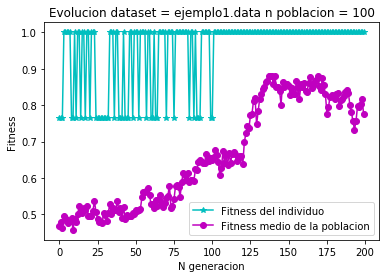

Best:  [[[0, 0], [0, 0], [1]], [[0, 1], [1, 0], [0]], [[0, 1], [1, 1], [1]], [[1, 0], [0, 1], [0]], [[1, 0], [1, 0], [1]]] | fit: 1.0


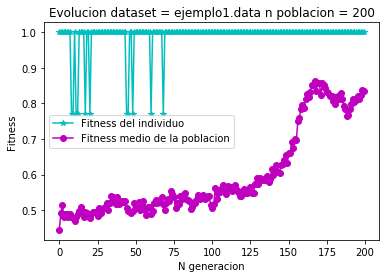

Best:  [[[0, 1], [0, 1], [1]], [[1, 0], [1, 1], [0]], [[1, 0], [0, 1], [0]], [[0, 1], [1, 1], [1]], [[1, 1], [1, 1], [1]]] | fit: 1.0


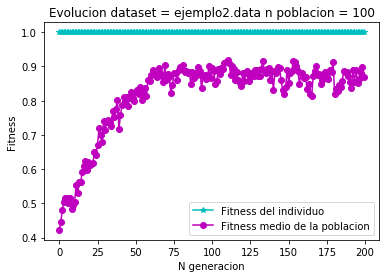

Best:  [[[1, 0], [1, 1], [0]], [[0, 0], [1, 1], [1]], [[0, 1], [1, 1], [1]], [[0, 1], [1, 0], [1]], [[1, 0], [0, 1], [0]]] | fit: 1.0


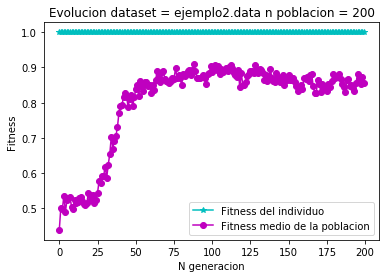

In [7]:
for d, v in d_dataset.items():
    for i in tam_pob:
        ag = Clasificador_AG(dataset=v, estrategia=e1, mostrar_proceso=False, plots=True, n_reglas=5, poblacion=i, generacion=200)
        e1.creaParticiones(v.datos, seed=seed)
        train = e1.particiones[-1].indicesTrain
        datostrain = v.extraeDatos(train)
        mejor_l_fit, mejor_l_pob = ag.entrenamiento(datostrain, v.nominalAtributos, v.diccionarios)
        graficas_a4('Evolucion dataset = '+ str(d) + ' n poblacion = '+ str(i), mejor_l_fit, mejor_l_pob)

$ValidacionCruzada$

Best:  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1]], [[1, 1, 0], [1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 0, 1], [1, 1, 0], [1, 1, 0], [1, 1, 1], [0, 0, 1], [1]], [[1, 1, 0], [1, 0, 1], [0, 1, 1], [0, 1, 1], [1, 0, 0], [1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 0], [0]], [[0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [0, 1, 1], [0, 1, 0], [1, 0, 1], [1, 0, 1], [0]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [0, 0, 0], [0, 0, 1], [1, 0, 1], [0, 1, 1], [1, 1, 0], [1]]] | fit: 0.6597131681877445


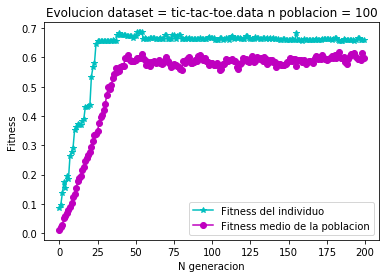

Best:  [[[0, 1, 0], [1, 1, 0], [0, 1, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [1, 0, 1], [0, 1, 0], [0, 0, 0], [0]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1]], [[0, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 1], [0, 1, 0], [0]], [[1, 1, 0], [0, 1, 0], [1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0], [1, 1, 1], [1, 1, 1], [0, 1, 1], [1]], [[0, 0, 1], [0, 1, 0], [1, 1, 1], [0, 1, 1], [0, 0, 1], [0, 1, 1], [1, 0, 0], [0, 0, 1], [1, 1, 0], [0]]] | fit: 0.6610169491525424


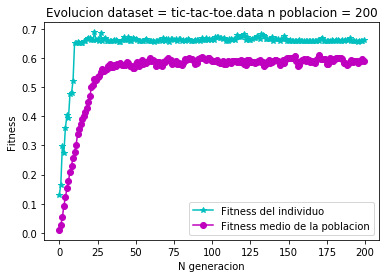

Best:  [[[0, 1], [1, 0], [0]], [[0, 1], [0, 1], [1]], [[1, 0], [1, 1], [1]], [[1, 0], [0, 1], [0]], [[0, 0], [0, 1], [1]]] | fit: 1.0


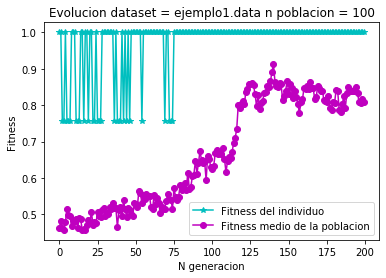

Best:  [[[1, 0], [1, 0], [1]], [[1, 1], [0, 0], [0]], [[1, 1], [1, 1], [1]], [[0, 1], [0, 1], [1]], [[1, 1], [1, 1], [0]]] | fit: 1.0


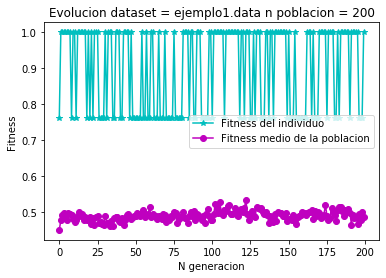

Best:  [[[1, 0], [1, 1], [0]], [[1, 0], [1, 1], [1]], [[1, 0], [1, 1], [0]], [[1, 0], [0, 0], [1]], [[0, 1], [1, 1], [1]]] | fit: 1.0


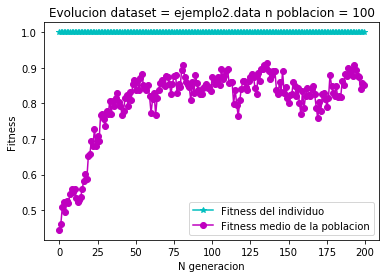

Best:  [[[1, 1], [1, 1], [1]], [[1, 0], [1, 0], [0]], [[1, 0], [1, 1], [0]], [[1, 1], [1, 1], [0]], [[0, 1], [1, 1], [1]]] | fit: 1.0


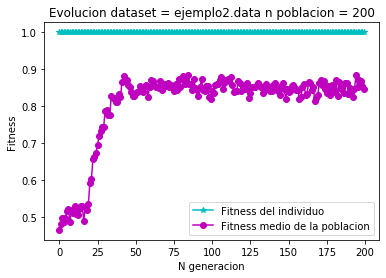

In [8]:
for d, v in d_dataset.items():
    for i in tam_pob:
        ag = Clasificador_AG(dataset=v, estrategia=e2, mostrar_proceso=False, plots=True, n_reglas=5, poblacion=i, generacion=200)
        e1.creaParticiones(v.datos, seed=seed)
        train = e1.particiones[-1].indicesTrain
        datostrain = v.extraeDatos(train)
        mejor_l_fit, mejor_l_pob = ag.entrenamiento(datostrain, v.nominalAtributos, v.diccionarios)
        graficas_a4('Evolucion dataset = '+ str(d) + ' n poblacion = '+ str(i), mejor_l_fit, mejor_l_pob)

##### Probamos ahora con 10 reglas y 200 generaciones.

$ValidacionSimple$

Best:  [[[0, 1, 0], [0, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 1], [1, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0]], [[0, 1, 1], [0, 0, 1], [0, 1, 0], [0, 1, 1], [0, 1, 1], [1, 1, 0], [0, 0, 0], [0, 0, 1], [0, 0, 1], [1]], [[1, 0, 1], [0, 0, 1], [0, 0, 1], [0, 1, 1], [1, 0, 0], [0, 0, 1], [1, 0, 0], [1, 1, 0], [0, 1, 1], [0]], [[1, 0, 0], [0, 0, 1], [0, 1, 1], [1, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 1], [1, 1, 1], [1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1]], [[1, 1, 1], [1, 0, 0], [1, 1, 1], [0, 1, 0], [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 0], [0, 0, 1], [1]], [[0, 0, 1], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 0, 1], [1, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 0], [1]], [[1, 1, 0], [0, 0, 1], [1, 0, 1], [0, 1, 0], [1, 0, 1], [1, 1, 1], [0, 1, 0], [1, 1, 1], [1, 1, 0], [0]], [[0, 1, 1], [0, 0, 1], [1, 0, 0], [0, 1, 1], [1, 1, 0], [1, 1, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0]], [[1, 1, 1], [1, 0, 0], [1, 1, 0], [1, 

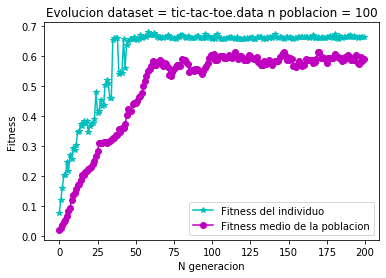

Best:  [[[0, 1, 0], [1, 0, 1], [1, 0, 1], [0, 1, 1], [0, 1, 1], [0, 1, 1], [1, 0, 1], [0, 0, 1], [0, 1, 0], [0]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1]], [[1, 1, 0], [0, 1, 1], [1, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 1, 0], [0]], [[1, 1, 1], [0, 0, 1], [1, 0, 1], [0, 0, 1], [1, 0, 0], [1, 1, 1], [0, 0, 1], [1, 1, 1], [1, 0, 1], [1]], [[0, 0, 1], [0, 1, 0], [1, 1, 1], [0, 1, 1], [0, 1, 1], [0, 1, 0], [0, 0, 1], [0, 1, 0], [1, 1, 0], [1]], [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, 0], [0, 1, 1], [1, 0, 1], [0, 0, 1], [1]], [[1, 1, 1], [1, 1, 1], [0, 1, 0], [1, 1, 1], [1, 1, 0], [0, 0, 1], [0, 1, 0], [0, 0, 1], [1, 0, 1], [0]], [[1, 1, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0], [1, 0, 1], [0, 0, 0], [1, 0, 0], [0, 0, 1], [0]], [[0, 1, 1], [0, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 0], [0, 1, 1], [1, 1, 0], [0, 1, 0], [1, 1, 0], [0]], [[0, 1, 1], [1, 0, 0], [0, 0, 1], [1, 

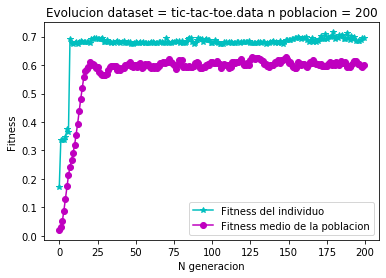

Best:  [[[0, 1], [1, 0], [0]], [[0, 0], [0, 1], [0]], [[1, 0], [0, 0], [0]], [[0, 1], [1, 0], [1]], [[0, 1], [0, 1], [1]], [[0, 0], [0, 1], [1]], [[0, 0], [0, 1], [1]], [[1, 0], [1, 0], [1]], [[1, 0], [1, 0], [1]], [[1, 0], [0, 1], [0]]] | fit: 1.0


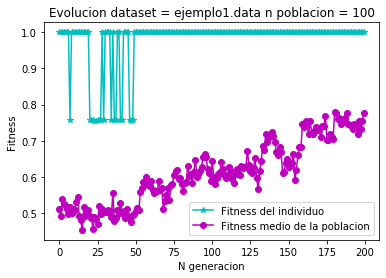

Best:  [[[1, 0], [0, 0], [0]], [[0, 1], [1, 0], [0]], [[0, 0], [0, 1], [1]], [[0, 1], [0, 1], [1]], [[1, 0], [0, 0], [0]], [[1, 0], [0, 1], [0]], [[1, 0], [1, 0], [1]], [[0, 1], [1, 0], [0]], [[1, 1], [0, 0], [0]], [[1, 1], [0, 1], [1]]] | fit: 1.0


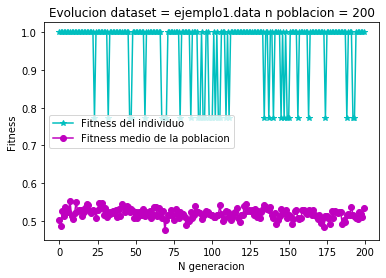

Best:  [[[0, 1], [1, 1], [1]], [[0, 1], [1, 1], [0]], [[1, 0], [0, 1], [0]], [[1, 0], [1, 1], [0]], [[0, 1], [0, 1], [1]], [[0, 0], [0, 1], [1]], [[0, 1], [1, 1], [1]], [[0, 1], [0, 1], [0]], [[0, 1], [1, 0], [1]], [[1, 1], [1, 1], [1]]] | fit: 1.0


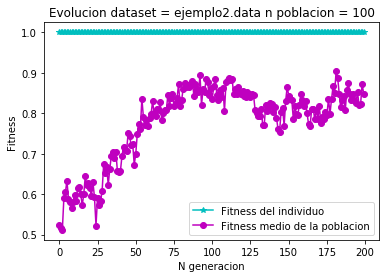

Best:  [[[1, 0], [1, 0], [1]], [[0, 1], [1, 1], [0]], [[1, 0], [1, 0], [0]], [[0, 1], [0, 1], [1]], [[0, 1], [1, 1], [1]], [[0, 0], [1, 0], [1]], [[1, 0], [1, 1], [0]], [[1, 0], [1, 1], [0]], [[1, 1], [1, 1], [1]], [[0, 1], [0, 1], [1]]] | fit: 1.0


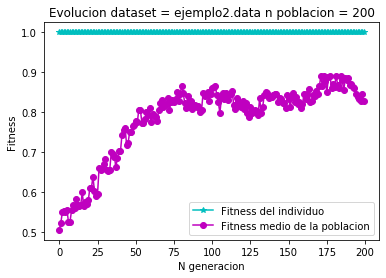

In [9]:
for d, v in d_dataset.items():
    for i in tam_pob:
        ag = Clasificador_AG(dataset=v, estrategia=e1, mostrar_proceso=False, plots=True, n_reglas=10, poblacion=i, generacion=200)
        e1.creaParticiones(v.datos, seed=seed)
        train = e1.particiones[-1].indicesTrain
        datostrain = v.extraeDatos(train)
        mejor_l_fit, mejor_l_pob = ag.entrenamiento(datostrain, v.nominalAtributos, v.diccionarios)
        graficas_a4('Evolucion dataset = '+ str(d) + ' n poblacion = '+ str(i), mejor_l_fit, mejor_l_pob)

$ValidacionCruzada$

Best:  [[[0, 0, 0], [1, 0, 1], [1, 0, 0], [1, 1, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1], [1, 1, 1], [1, 1, 0], [1]], [[0, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [0, 1, 0], [1, 0, 1], [0, 0, 1], [1, 1, 0], [1, 1, 0], [0]], [[0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 0, 0], [0, 1, 0], [1, 0, 1], [1]], [[1, 0, 1], [1, 1, 1], [1, 1, 1], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 1], [1, 0, 0], [0, 0, 1], [0]], [[0, 1, 0], [0, 0, 1], [0, 0, 0], [0, 1, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [0, 1, 1], [1, 1, 1], [0]], [[0, 1, 1], [1, 1, 0], [1, 0, 1], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 1, 1], [0]], [[0, 1, 1], [0, 0, 1], [0, 0, 0], [0, 1, 1], [0, 1, 0], [0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 0, 0], [1]], [[0, 1, 1], [1, 0, 1], [1, 0, 1], [1, 1, 1], [1, 1, 0], [0, 1, 1], [1, 0, 1], [0, 1, 1], [1, 1, 1], [1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1]], [[0, 1, 0], [1, 1, 1], [1, 0, 1], [1, 

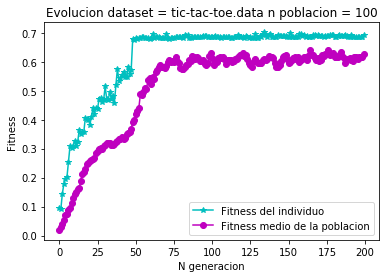

Best:  [[[0, 0, 0], [1, 1, 0], [0, 1, 1], [1, 1, 1], [1, 0, 0], [0, 1, 1], [0, 0, 1], [1, 1, 1], [1, 1, 1], [1]], [[0, 1, 1], [1, 0, 0], [1, 1, 1], [1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 0, 1], [1, 1, 0], [0, 1, 1], [0]], [[0, 1, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], [0, 0, 1], [0, 1, 1], [1, 1, 1], [1, 0, 0], [0, 0, 1], [1]], [[0, 0, 1], [1, 1, 1], [1, 0, 1], [0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 0, 1], [0, 1, 1], [1, 1, 1], [0]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1]], [[1, 1, 1], [0, 1, 0], [1, 0, 1], [1, 1, 1], [1, 1, 0], [0, 0, 1], [0, 0, 0], [0, 1, 1], [0, 0, 0], [0]], [[1, 0, 1], [1, 1, 0], [0, 1, 1], [1, 0, 1], [1, 1, 0], [0, 1, 0], [1, 1, 0], [0, 0, 0], [0, 1, 0], [1]], [[0, 1, 0], [1, 1, 1], [0, 1, 1], [1, 1, 1], [1, 1, 0], [1, 0, 1], [1, 1, 1], [1, 0, 1], [1, 1, 1], [0]], [[0, 1, 1], [1, 0, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [0, 0, 1], [0, 0, 0], [1, 1, 0], [0, 1, 0], [0]], [[0, 1, 0], [1, 1, 1], [1, 1, 0], [0, 

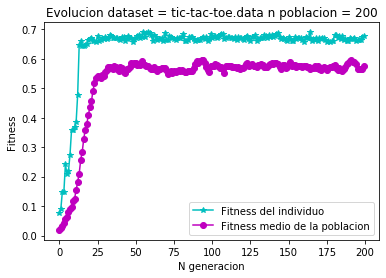

Best:  [[[1, 0], [1, 0], [1]], [[1, 0], [1, 1], [0]], [[1, 1], [1, 0], [1]], [[1, 0], [0, 0], [1]], [[0, 0], [0, 1], [1]], [[0, 1], [1, 0], [0]], [[1, 0], [0, 0], [1]], [[0, 1], [0, 1], [1]], [[1, 0], [0, 1], [0]], [[1, 0], [0, 0], [1]]] | fit: 1.0


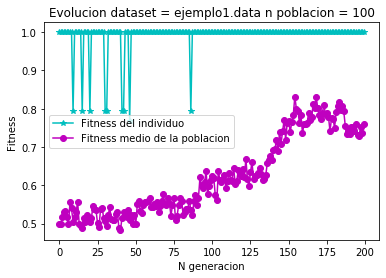

Best:  [[[0, 1], [0, 1], [1]], [[0, 0], [1, 1], [0]], [[1, 1], [1, 0], [0]], [[1, 1], [0, 0], [1]], [[1, 0], [1, 0], [1]], [[0, 1], [1, 0], [0]], [[0, 0], [1, 0], [0]], [[1, 0], [1, 1], [0]], [[1, 0], [0, 0], [0]], [[0, 0], [1, 1], [0]]] | fit: 0.7892857142857143


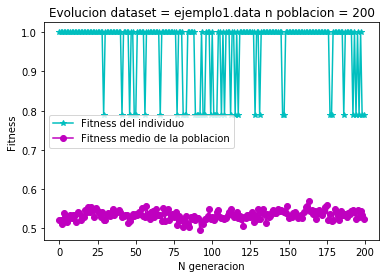

Best:  [[[0, 0], [1, 1], [1]], [[0, 1], [1, 1], [1]], [[1, 0], [0, 1], [1]], [[1, 0], [1, 1], [0]], [[1, 0], [1, 1], [0]], [[0, 0], [0, 0], [0]], [[0, 1], [1, 1], [1]], [[0, 1], [0, 1], [1]], [[1, 1], [0, 1], [0]], [[0, 1], [1, 1], [1]]] | fit: 1.0


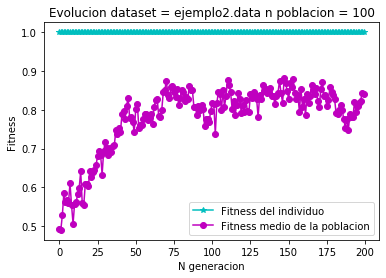

Best:  [[[1, 0], [1, 1], [0]], [[0, 1], [1, 0], [1]], [[1, 0], [1, 1], [0]], [[0, 1], [1, 1], [1]], [[1, 1], [0, 1], [1]], [[1, 0], [0, 0], [1]], [[0, 1], [1, 1], [1]], [[0, 1], [0, 0], [1]], [[1, 1], [1, 1], [1]], [[0, 0], [1, 1], [0]]] | fit: 1.0


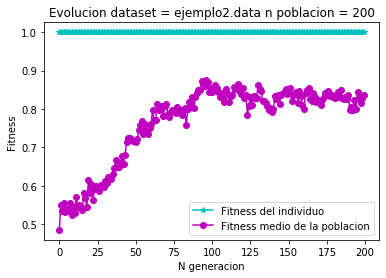

In [10]:
for d, v in d_dataset.items():
    for i in tam_pob:
        ag = Clasificador_AG(dataset=v, estrategia=e1, mostrar_proceso=False, plots=True, n_reglas=10, poblacion=i, generacion=200)
        e1.creaParticiones(v.datos, seed=seed)
        train = e1.particiones[-1].indicesTrain
        datostrain = v.extraeDatos(train)
        mejor_l_fit, mejor_l_pob = ag.entrenamiento(datostrain, v.nominalAtributos, v.diccionarios)
        graficas_a4('Evolucion dataset = '+ str(d) + ' n poblacion = '+ str(i), mejor_l_fit, mejor_l_pob)

Nota: se comprueba que no hay grandes diferencias en utilizar validación cruzada o validación simple, pero se valora la importancia de utilizar validación cruzada, ya que obtenemos mucho más confianza en la ejecución. A pesar de que el algoritmo no tarda demasiado, es decir, minutos, y a la vista de que no hay notables diferencias, se elije validación simple ya que no consume tantos recursos.